# DMRG : Modern MPS (Matrix product state) version

Edited by [Min Long](https://quantummc.xyz/members/min-long/) in October 2023.

Revised by [ZYM](https://quantummc.xyz/members/ziyang-meng/) in February 2026.

This is a notebook on modern DMRG algorithm written in Matrix product states(MPS) formalism. The code shown in this notebook is adapted from Internet and revised by Min Long.

For further information, one can read the reference articles of this notebook by Schollwoeck [arXiv:1008.3477](https://arxiv.org/abs/1008.3477v2).

In [2]:
import numpy as np
import scipy
import scipy.sparse.linalg
import scipy.sparse as sparse
import math
import matplotlib.pyplot as plt
import numpy.linalg as npla

## Work flow explaination

Similar as the block enlargement method, we are dealing with a Hamilonian with form
$$
H = H^L_{eff} \otimes H_i \otimes H^R_{eff}
$$
where $H^L_{eff}$ is the Hamiltonian of the left chain written in the basis of low energy eigenstate, this is achieved by contracting all the left tensors, as shown in the figure, like wise for $H^R_{eff}$.


![Alt text](https://github.com/DavidGoing/DMRG/blob/main/figures/workflow.png?raw=true)

After the diagonalization, we perform SVD to move to next site.


## Explaination of the variables
- W : Matrix product operator form of the Heisenberg chain (at all the $H_i$).
- A : Left canonical state.
- B : Right canonical state.
- E : Left vacum state to store the information of contraction from left at each step ($H^L_{eff}$ in each step, and update every time when SVD is performed).
- F : Right vacuum state with same use ($H^R_{eff}$ in each step, and update every time when SVD is performed).



In [3]:

## initial E and F matrices for the left and right vacuum states
def initial_E(W):
    E = np.zeros((W.shape[0], 1, 1))
    E[0] = 1
    return E


def initial_F(W):
    F = np.zeros((W.shape[1], 1, 1))
    F[-1] = 1
    return F

### Contraction function

Basically, the contraction is performed step be step. At nth site, the contraction from left to right is performed as showned below:

![Alt text](https://github.com/DavidGoing/DMRG/blob/main/figures/contraction.png?raw=true)

The contraction from right to left is performed as showned below:

![Alt text](https://github.com/DavidGoing/DMRG/blob/main/figures/contraction_r_l.png?raw=true)

In [4]:
def contract_from_left(W, A, E, B):
    # the einsum function doesn't appear to optimize the contractions properly,
    # so we split it into individual summations in the optimal order
    # return np.einsum("abst,sij,aik,tkl->bjl",W,A,E,B, optimize=True)
    Temp = np.einsum("sij,aik->sajk", A, E)
    Temp = np.einsum("sajk,abst->tbjk", Temp, W)
    return np.einsum("tbjk,tkl->bjl", Temp, B)

def contract_from_right(W, A, F, B):
    # the einsum function doesn't appear to optimize the contractions properly,
    # so we split it into individual summations in the optimal order
    # return np.einsum("abst,sij,bjl,tkl->aik",W,A,F,B, optimize=True)
    Temp = np.einsum("sij,bjl->sbil", A, F)
    Temp = np.einsum("sbil,abst->tail", Temp, W)
    return np.einsum("tail,tkl->aik", Temp, B)

## "Can you draw the from right by hand" ?

# construct the F-matrices for all sites except the first
def construct_F(Alist, MPO, Blist):
    F = [initial_F(MPO[-1])]

    for i in range(len(MPO) - 1, 0, -1):
        F.append(contract_from_right(MPO[i], Alist[i], F[-1], Blist[i]))
    return F


def construct_E(Alist, MPO, Blist):
    return [initial_E(MPO[0])]

def Expectation(AList, MPO, BList):
    E = [[[1]]]
    for i in range(0, len(MPO)):
        E = contract_from_left(MPO[i], AList[i], E, BList[i])
    return E[0][0][0]


#  A 5-site example

## From right to left (Recursive coding)
### 1. Setup and Initialization
Before starting the right-to-left sweep, we define our chain of 5 sites (indices 0, 1, 2, 3, 4).
The list `F` is initialized with the 'Right Vacuum' boundary.

* MPO Tensors: [W0, W1, W2, W3, W4]
* Initial State: F = [initial_F]

---

### 2. The `construct_F` Loop Trace
Loop: `for i in range(4, 0, -1):`
In each step, `F[-1]` is contracted with site `i` to grow the environment.


| Iteration | Site (i) | Operation (using F[-1]) | Physical Content | F List State |
| :--- | :--- | :--- | :--- | :--- |
| Start | — | — | Right Vacuum | [F_vac] |
| Step 1 | 4 | Contract(W4, F_vac) | Site 4 | [F_vac, F_4] |
| Step 2 | 3 | Contract(W3, F_4) | Sites 3 + 4 | [F_vac, F_4, F_34] |
| Step 3 | 2 | Contract(W2, F_34) | Sites 2 + 3 + 4 | [F_vac, F_4, F_34, F_234] |
| Step 4 | 1 | Contract(W1, F_234) | Sites 1 + 2 + 3 + 4 | [F_vac, F_4, F_34, F_234, F_1234] |

---

<br>

## From left to right
### 1. Setup and Initialization (Left-to-Right)
We define our chain of 5 sites (indices 0, 1, 2, 3, 4). The list `E` is initialized
with the 'Left Vacuum' boundary, which represents the vacuum state to the left of site 0.

* MPO Tensors: [W0, W1, W2, W3, W4]
* Initial State: E = [initial_E]

---

### 2. The `construct_E` Loop Trace
Loop: `for i in range(0, 4):`
In each step, `E[-1]` (the existing left wall) is contracted with site `i`
to grow the environment for the next site.


| Iteration | Site (i) | Operation (using E[-1]) | Physical Content | E List State |
| :--- | :--- | :--- | :--- | :--- |
| Start | — | — | Left Vacuum | [E_vac] |
| Step 1 | 0 | Contract(W0, E_vac) | Site 0 | [E_vac, E_0] |
| Step 2 | 1 | Contract(W1, E_0) | Sites 0 + 1 | [E_vac, E_0, E_01] |
| Step 3 | 2 | Contract(W2, E_01) | Sites 0 + 1 + 2 | [E_vac, E_0, E_01, E_012] |
| Step 4 | 3 | Contract(W3, E_012) | Sites 0 + 1 + 2 + 3 | [E_vac, E_0, E_01, E_012, E_0123] |

---


### Coarse graining and truncation function

To perform 2-site DMRG, we need to do coarse graining for states and operators.

For two site state, two site MPS or product of MPS, the idea of doing coarse graining is similar, we just view two bond at the same direction as one bond (with larger index), as illustrated in the figure below

![image.png](https://github.com/DavidGoing/DMRG/blob/main/figures/coarse_graining.png?raw=true)

In [5]:

# 2-1 coarse-graining of two site MPO into one site
def coarse_grain_MPO(W, X):
    return np.reshape(np.einsum("abst,bcuv->acsutv", W, X),
                      [W.shape[0], X.shape[1],
                       W.shape[2] * X.shape[2],
                       W.shape[3] * X.shape[3]])

def product_W(W1, W2):
    return np.reshape(np.einsum("abst,cdtu->acbdsu", W1, W2), [W1.shape[0] * W2.shape[0],
                                                               W1.shape[1] * W2.shape[1],
                                                               W1.shape[2], W2.shape[3]])

def product_MPO(M1, M2):
    assert len(M1) == len(M2)
    Result = []
    for i in range(0, len(M1)):
        Result.append(product_W(M1[i], M2[i]))
    return Result

# 2-1 coarse-graining of two-site MPS into one site
def coarse_grain_MPS(A, B):
    return np.reshape(np.einsum("sij,tjk->stik", A, B),
                      [A.shape[0] * B.shape[0], A.shape[1], B.shape[2]])

#   Fine grain
#
#           (d1 * d2)
#               |
#    ---(χL)---[ A ]---(χR)---

#          (d1)     (d2)          <-- Physical legs split
#           |        |
#    ---(χL)---[ Θ ]---(χR)---    <-- Indices grouped as (0, 2) and (1, 3)

#         (d1)                (d2)
#           |                   |
#  ---(χL)[ U ]---(S)---(S)---[ V ](χR)---


def fine_grain_MPS(A, dims):
    assert A.shape[0] == dims[0] * dims[1]
    Theta = np.transpose(np.reshape(A, dims + [A.shape[1], A.shape[2]]),
                         (0, 2, 1, 3))
    M = np.reshape(Theta, (dims[0] * A.shape[1], dims[1] * A.shape[2]))
    U, S, V = np.linalg.svd(M, full_matrices=0)
    U = np.reshape(U, (dims[0], A.shape[1], -1))
    V = np.transpose(np.reshape(V, (-1, dims[1], A.shape[2])), (1, 0, 2))
    # assert U is left-orthogonal
    # assert V is right-orthogonal
    # print(np.dot(V[0],np.transpose(V[0])) + np.dot(V[1],np.transpose(V[1])))
    return U, S, V

def truncate_MPS(U, S, V, m):
    m = min(len(S), m)
    trunc = np.sum(S[m:])
    S = S[0:m]
    U = U[:, :, 0:m]
    V = V[:, 0:m, :]
    return U, S, V, trunc, m

### Work flow : Procedure of DMRG

Define the Hamiltonian based on the transformation of the vector instead of the matrix elements. It is a common way to define a large spase matrix. Then diagonalize the matrix using Lancoz method.

![image.png](https://github.com/DavidGoing/DMRG/blob/main/figures/workflow.png?raw=true)

From the diagram expression of the Hamiltonain, we see that this Hamiltonian transform tensors.

In [6]:
class HamiltonianMultiply(sparse.linalg.LinearOperator):
    def __init__(self, E, W, F):
        self.E = E
        self.W = W
        self.F = F
        self.dtype = np.dtype('d')
        self.req_shape = [W.shape[2], E.shape[1], F.shape[1]]
        # self.req_shape = [W.shape[2], E.shape[1], F.shape[2]] ORIGINAL VERSION
        self.size = self.req_shape[0] * self.req_shape[1] * self.req_shape[2]
        self.shape = [self.size, self.size]

    def _matvec(self, A):
        # the einsum function doesn't appear to optimize the contractions properly,
        # so we split it into individual summations in the optimal order
        # R = np.einsum("aij,sik,abst,bkl->tjl",self.E,np.reshape(A, self.req_shape),
        #              self.W,self.F, optimize=True)
        R = np.einsum("aij,sik->ajsk", self.E, np.reshape(A, self.req_shape))
        R = np.einsum("ajsk,abst->bjtk", R, self.W)
        R = np.einsum("bjtk,bkl->tjl", R, self.F)
        return np.reshape(R, -1)


## optimize a single site given the MPO matrix W, and tensors E,F
def optimize_site(A, W, E, F):
    H = HamiltonianMultiply(E, W, F)
    # we choose tol=1E-8 here, which is OK for small calculations.
    # to bemore robust, we should take the tol -> 0 towards the end
    # of the calculation.
    E, V = sparse.linalg.eigsh(H, 1, v0=A, which='SA', tol=1E-8)
    return (E[0], np.reshape(V[:, 0], H.req_shape))


def optimize_two_sites(A, B, W1, W2, E, F, m, dir):
    W = coarse_grain_MPO(W1, W2)
    AA = coarse_grain_MPS(A, B)
    H = HamiltonianMultiply(E, W, F)
    E, V = sparse.linalg.eigsh(H, 1, v0=AA, which='SA')
    AA = np.reshape(V[:, 0], H.req_shape)
    A, S, B = fine_grain_MPS(AA, [A.shape[0], B.shape[0]])
    A, S, B, trunc, m = truncate_MPS(A, S, B, m)
    if (dir == 'right'):
        B = np.einsum("ij,sjk->sik", np.diag(S), B)
    else:
        assert dir == 'left'
        A = np.einsum("sij,jk->sik", A, np.diag(S))
    return E[0], A, B, trunc, m


def two_site_dmrg(MPS, MPO, m, sweeps):
    E = construct_E(MPS, MPO, MPS)
    F = construct_F(MPS, MPO, MPS)
    F.pop()
    for sweep in range(0, int(sweeps / 2)):
        for i in range(0, len(MPS) - 2):
            Energy, MPS[i], MPS[i + 1], trunc, states = optimize_two_sites(MPS[i], MPS[i + 1],
                                                                           MPO[i], MPO[i + 1],
                                                                           E[-1], F[-1], m, 'right')
            print("Sweep {:} Sites {:},{:}    Energy {:16.12f}    States {:4} Truncation {:16.12f}"
                  .format(sweep * 2, i, i + 1, Energy, states, trunc))
            E.append(contract_from_left(MPO[i], MPS[i], E[-1], MPS[i]))
            F.pop();
        for i in range(len(MPS) - 2, 0, -1):
            Energy, MPS[i], MPS[i + 1], trunc, states = optimize_two_sites(MPS[i], MPS[i + 1],
                                                                           MPO[i], MPO[i + 1],
                                                                           E[-1], F[-1], m, 'left')
            print("Sweep {} Sites {},{}    Energy {:16.12f}    States {:4} Truncation {:16.12f}"
                  .format(sweep * 2 + 1, i, i + 1, Energy, states, trunc))
            F.append(contract_from_right(MPO[i + 1], MPS[i + 1], F[-1], MPS[i + 1]))
            E.pop();
    return MPS


In [7]:


d = 2  # local bond dimension
N = 40  # number of sites
D = 32 # virtue bond dimension

InitialA1 = np.zeros((d, 1, 1))
InitialA1[0, 0, 0] = 1
InitialA2 = np.zeros((d, 1, 1))
InitialA2[1, 0, 0] = 1

## initial state |01010101>
MPS = [InitialA1, InitialA2] * int(N / 2)

## Local operators
I = np.identity(2)
Z = np.zeros((2, 2))
Sz = np.array([[0.5, 0],
               [0, -0.5]])
Sp = np.array([[0, 0],
               [1, 0]])
Sm = np.array([[0, 1],
               [0, 0]])

## Hamiltonian MPO
W = np.array([[I, Sz, 0.5 * Sp, 0.5 * Sm, Z],
              [Z, Z, Z, Z, Sz],
              [Z, Z, Z, Z, Sm],
              [Z, Z, Z, Z, Sp],
              [Z, Z, Z, Z, I]])

Wfirst = np.array([[I, Sz, 0.5 * Sp, 0.5 * Sm, Z]])

Wlast = np.array([[Z], [Sz], [Sm], [Sp], [I]])

# the complete MPO
MPO = [Wfirst] + ([W] * (N - 2)) + [Wlast]

# 8 sweeps with m=10 states


### Test region

In [8]:
print(np.shape(Wfirst))
print(np.shape(Wlast))
print(np.shape(initial_F(Wlast)))
print(np.shape(initial_E(Wfirst)))

(1, 5, 2, 2)
(5, 1, 2, 2)
(1, 1, 1)
(1, 1, 1)


### Run DMRG

In [9]:
HamSquared = product_MPO(MPO, MPO)

Gs = two_site_dmrg(MPS, MPO, D, 8)

Energy = Expectation(Gs, MPO, Gs)
print("Final energy expectation value {}".format(Energy))

H2 = Expectation(Gs, HamSquared, Gs)
print("variance = {:16.12f}".format(H2 - Energy * Energy))

Sweep 0 Sites 0,1    Energy -10.059016994375    States    2 Truncation   0.000000000000
Sweep 0 Sites 1,2    Energy -10.189692620786    States    2 Truncation   0.000000000000
Sweep 0 Sites 2,3    Energy -10.395800958670    States    2 Truncation   0.000000000000
Sweep 0 Sites 3,4    Energy -10.560586239348    States    2 Truncation   0.000000000000
Sweep 0 Sites 4,5    Energy -10.743669962857    States    2 Truncation   0.000000000000
Sweep 0 Sites 5,6    Energy -10.917602338044    States    2 Truncation   0.000000000000
Sweep 0 Sites 6,7    Energy -11.095754582728    States    2 Truncation   0.000000000000
Sweep 0 Sites 7,8    Energy -11.271867353000    States    2 Truncation   0.000000000000
Sweep 0 Sites 8,9    Energy -11.448938381096    States    2 Truncation   0.000000000000
Sweep 0 Sites 9,10    Energy -11.625551828355    States    2 Truncation   0.000000000000
Sweep 0 Sites 10,11    Energy -11.802381755193    States    2 Truncation   0.000000000000
Sweep 0 Sites 11,12    Energy

# Measurement

In [10]:
psi = [np.copy(Gs[i]) for i in range(0, len(Gs))]

In [11]:
def multi_site_measurement(MPS1,MPS2,op_list,pos_list):
    idx = np.argsort(pos_list)
    pos_list = np.array(pos_list)[idx]
    op_list = np.array(op_list)[idx]
    expectation = [[1]]
    # print(op_list,pos_list)
    assert len(op_list) == len(pos_list)
    for j in range(0, pos_list[0]):
        expectation = np.einsum("ik,sij->skj", expectation, MPS1[j])
        expectation = np.einsum("skj,skl->jl",  expectation,MPS2[j].conjugate())
    expectation = np.einsum('ik,sij,st,tkl->jl', expectation, MPS1[pos_list[0]], op_list[0], MPS2[pos_list[0]].conjugate())
    for i in range(len(op_list)-1):
        for j in range(pos_list[i]+1,pos_list[i+1]):
            expectation = np.einsum("ik,sij->skj", expectation, MPS1[j])
            expectation = np.einsum("skj,skl->jl", expectation,MPS2[j].conjugate())
        expectation = np.einsum('ik,sij,st,tkl->jl', expectation, MPS1[pos_list[i+1]], op_list[i+1], MPS2[pos_list[i+1]].conjugate())
    for j in range(pos_list[-1]+1,len(MPS1)):
        expectation = np.einsum("ik,sij->skj", expectation, MPS1[j])
        expectation = np.einsum("skj,skl->jl", expectation,MPS2[j].conjugate())
    return expectation[0][0]
def check_othogonal(MPS):
    infor_string = []
    for ten in MPS:
        matl = np.einsum("sij,sik->jk",ten,ten)
        matr = np.einsum("sij,slj->il",ten,ten)
        dim = matl.shape[0]
        Il = np.identity(dim)
        Ir = np.identity(matr.shape[0])
        if npla.norm(matl-Il)<1e-10:
            infor_string.append('A')
        if npla.norm(matr-Ir)<1e-10:
            infor_string.append('B')
        if not(npla.norm(matl-Il)<1e-10 or npla.norm(matr-Ir)<1e-10):
            infor_string.append('M')
    return ' '.join(infor_string)

def move_mix_site(start ,end , mix_MPS ,bond_dim):
    if end > start:
        move_dir = 'r'
        for i in range(start,end,1):
            M1 = mix_MPS[i]
            M_mat = np.reshape(M1,(M1.shape[0]*M1.shape[1],M1.shape[2]))
            A, S, B = np.linalg.svd(M_mat, full_matrices=0)
            trunc_dim = min(bond_dim,len(S))
            A = A[:,0:trunc_dim]
            S = S[0:trunc_dim]
            B = B[0:trunc_dim,:]
            # print(npla.norm(A@np.diag(S)@B-M_mat))
            trunc = np.sum(S[trunc_dim:])
            A = np.reshape(A,(M1.shape[0],M1.shape[1],-1))
            # print("Truncation error in moving from site {} to {} : {}".format(i,i+1,trunc))
            if trunc > 1e-10:
                raise Exception("large truncation error")
            B = np.diag(S)@B
            mix_MPS[i] =  A
            mix_MPS[i+1] = np.einsum("ij,sjk->sik",B,mix_MPS[i+1])
    if end < start:
        move_dir = 'l'
        for i in range(start,end,-1):
            M1 = mix_MPS[i]
            M_mat = np.reshape(M1.transpose(1,0,2), (M1.shape[1], M1.shape[0] * M1.shape[2]))
            A, S, B = np.linalg.svd(M_mat, full_matrices=0)
            trunc_dim = min(bond_dim, len(S))
            A = A[:, 0:trunc_dim]
            S = S[0:trunc_dim]
            B = B[0:trunc_dim, :]
            # print(npla.norm(A @ np.diag(S) @ B - M_mat))
            trunc = np.sum(S[trunc_dim:])
            B = np.reshape(B, (-1,M1.shape[0], M1.shape[2])).transpose(1,0,2)
            # print("Truncation error in moving from site {} to {} : {}".format(i, i + 1, trunc))
            if trunc > 1e-10:
                raise Exception("large truncation error")
            A = A@np.diag(S)
            mix_MPS[i] = B
            mix_MPS[i - 1] = np.einsum("sjk,kl->sjl", mix_MPS[i-1], A)
    if end == start:
        pass
    return mix_MPS

## magnetization

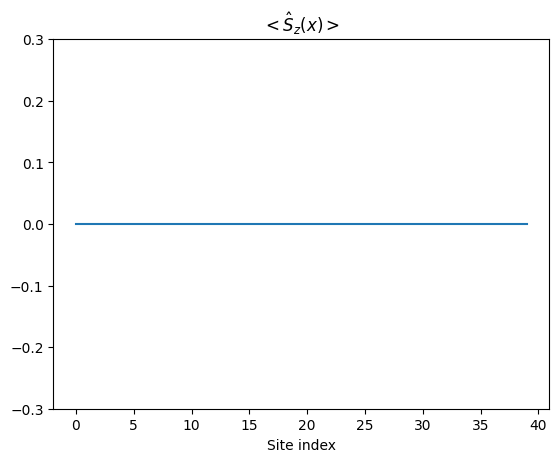

In [12]:
def plot_Sz_r_MPS(MPS_in):
    Sz_correlation = []
    for i in range(N):
        Sz_correlation.append(multi_site_measurement(MPS_in, MPS_in, [Sz], [i]))
    plt.plot(Sz_correlation)
    plt.title(r"$<\hat{S}_z(x)>$")
    plt.xlabel("Site index")
    # plt.savefig("temp")
    plt.ylim(-0.3, 0.3)
    plt.show()
    # plt.savefig("Sz_correlation_measurement")
    plt.close()
plot_Sz_r_MPS(psi)

## Sz Sz correlation

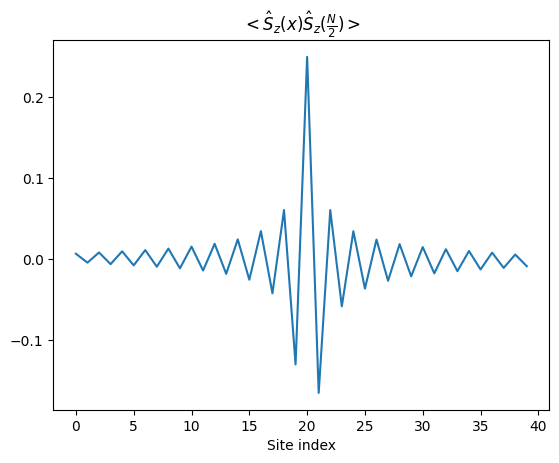

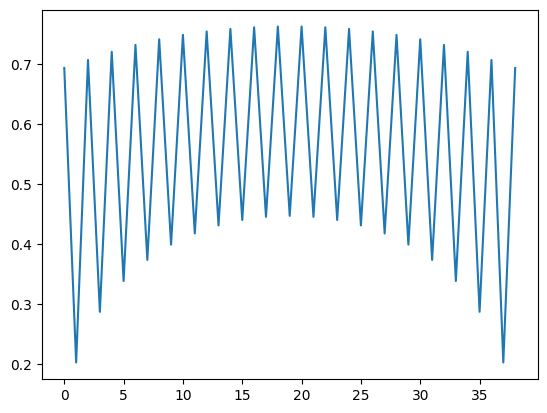

In [13]:
def plot_Sz_correlaion_MPS(MPS_in):
    Sz_correlation = []
    for i in range(N):
        if i != N//2:
            Sz_correlation.append(multi_site_measurement(MPS_in,MPS_in,[Sz,Sz],[i,N//2]))
        else:
            Sz_correlation.append(multi_site_measurement(MPS_in, MPS_in, [Sz@Sz], [i]))
    plt.plot(Sz_correlation)
    plt.title(r"$<\hat{S}_z(x)\hat{S}_z(\frac{N}{2})>$")
    plt.xlabel("Site index")
    # plt.savefig("temp")
    plt.show()
    # plt.savefig("Sz_correlation_measurement")
    plt.close()
plot_Sz_correlaion_MPS(psi)

#def bipartition_entropy(MPSbra,MPSket,pos_list):
###make an indentity list for multiplication
#   Product_factor_a = [[1]]
#   Product_factor_b = [[1]]
   ###imagine a 2x2x...x2 (L-dimensional) matrix, flattern it into a (2^a x 2^b, a+b=L) 2D matrix
   ###But here the Fock space is truncted,
#   for i in range(0,pos_list[0]+1):#merge MPS(  1~ i) into a part, D_i x D_i
#       Product_factor_a=np.einsum("iS,jSK->jSK", Product_factor_a, MPSbra[i])
#       Product_factor_a=np.einsum("jSK,jSL->KL", Product_factor_a, MPSket[i].conjugate())
#       #print("a",i,Product_factor_a.shape)
#   for i in range(N-1,pos_list[0],-1):#merge MPS(i+1~ L) into b part,D x D
#       Product_factor_b=np.einsum("iK,jSK->jSK", Product_factor_b, MPSbra[i])
#       Product_factor_b=np.einsum("jSK,jLK->SL", Product_factor_b, MPSket[i].conjugate())
       #print("b",i,Product_factor_b.shape)
   #merge a part and b part
#   rho=Product_factor_a*Product_factor_b.conjugate().transpose()
#   entropy=-math.log(np.trace(np.square(rho)))
#   return entropy

#def plot_entropy(MPS):
#bipar_entro=[]
#for i in range(N-1):
#       bipar_entro.append(bipartition_entropy(Gs,Gs,[i]))
#plt.plot(bipar_entro)

## Entanglement entrophy

Orthogonality check passed, orthogonality center at site 1


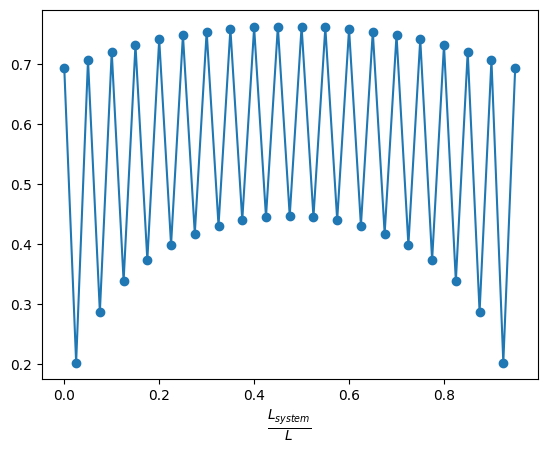

In [14]:
psi = [np.copy(Gs[i]) for i in range(0, len(Gs))]
ortho_info = check_othogonal(psi).split(" ")
for i in enumerate(ortho_info):
    if i[1] == "M":
        ortho_pos = i[0]
        break
for (i,char) in enumerate(ortho_info):
    if i<ortho_pos and char != "A":
        raise Exception("Left orthogonal error at site {}".format(i))
    if i>ortho_pos and char != "B":
        raise Exception("Right orthogonal error at site {}".format(i))
print("Orthogonality check passed, orthogonality center at site {}".format(ortho_pos))

psi = move_mix_site(ortho_pos,0,psi,D)
EE_list = []
for i in range(N-1):
    M1 = psi[i]
    M_mat = np.reshape(M1,(M1.shape[0]*M1.shape[1],M1.shape[2]))
    A, S, B = np.linalg.svd(M_mat, full_matrices=0)
    trunc_dim = min(D,len(S))
    A = A[:,0:trunc_dim]
    S = S[0:trunc_dim]
    # print(S)
    B = B[0:trunc_dim,:]
    order = 2
    EE = (1/(1-order))*np.log(np.sum((S**2)**order)) #-np.sum(S**2*np.log(S**2))
    EE_list.append(EE)
    A = np.reshape(A,(M1.shape[0],M1.shape[1],-1))
    # print("Truncation error in moving from site {} to {} : {}".format(i,i+1,trunc))
    B = np.diag(S)@B
    psi[i] =  A
    psi[i+1] = np.einsum("ij,sjk->sik",B,psi[i+1])
move_mix_site(N-1,0,psi,D)
plt.plot(np.arange(N-1)/N,EE_list,'o-')

plt.xlabel(r'$\frac{L_{system}}{L}$',fontsize = 14)
plt.show()
# plt.savefig("Sz_correlation_measurement")
plt.close()



# Scaling

In [15]:

d = 2  # local bond dimension
totEE = []
for N in [16,32,48]:  # number of sites
    D = 32 # virtue bond dimension

    InitialA1 = np.zeros((d, 1, 1))
    InitialA1[0, 0, 0] = 1
    InitialA2 = np.zeros((d, 1, 1))
    InitialA2[1, 0, 0] = 1

    ## initial state |01010101>
    MPS = [InitialA1, InitialA2] * int(N / 2)

    ## Local operators
    I = np.identity(2)
    Z = np.zeros((2, 2))
    Sz = np.array([[0.5, 0],
                [0, -0.5]])
    Sp = np.array([[0, 0],
                [1, 0]])
    Sm = np.array([[0, 1],
                [0, 0]])

    ## Hamiltonian MPO
    W = np.array([[I, Sz, 0.5 * Sp, 0.5 * Sm, Z],
                [Z, Z, Z, Z, Sz],
                [Z, Z, Z, Z, Sm],
                [Z, Z, Z, Z, Sp],
                [Z, Z, Z, Z, I]])

    Wfirst = np.array([[I, Sz, 0.5 * Sp, 0.5 * Sm, Z]])

    Wlast = np.array([[Z], [Sz], [Sm], [Sp], [I]])

    # the complete MPO
    MPO = [Wfirst] + ([W] * (N - 2)) + [Wlast]
    HamSquared = product_MPO(MPO, MPO)

    Gs = two_site_dmrg(MPS, MPO, D, 8)
    psi = [np.copy(Gs[i]) for i in range(0, len(Gs))]
    ortho_info = check_othogonal(psi).split(" ")
    for i in enumerate(ortho_info):
        if i[1] == "M":
            ortho_pos = i[0]
            break
    psi = move_mix_site(ortho_pos,0,psi,D)
    EE_list = []
    for i in range(N-1):
        M1 = psi[i]
        M_mat = np.reshape(M1,(M1.shape[0]*M1.shape[1],M1.shape[2]))
        A, S, B = np.linalg.svd(M_mat, full_matrices=0)
        trunc_dim = min(D,len(S))
        A = A[:,0:trunc_dim]
        S = S[0:trunc_dim]
        # print(S)
        B = B[0:trunc_dim,:]
        order = 2
        EE = (1/(1-order))*np.log(np.sum((S**2)**order)) #-np.sum(S**2*np.log(S**2))
        EE_list.append(EE)
        A = np.reshape(A,(M1.shape[0],M1.shape[1],-1))
        # print("Truncation error in moving from site {} to {} : {}".format(i,i+1,trunc))
        B = np.diag(S)@B
        psi[i] =  A
        psi[i+1] = np.einsum("ij,sjk->sik",B,psi[i+1])
    move_mix_site(N-1,0,psi,D)
    # plt.plot(np.arange(N-1)/N,EE_list,'o-',label = f"L = {N}, mm = 32")
    totEE.append(EE_list)


Sweep 0 Sites 0,1    Energy  -4.059016994375    States    2 Truncation   0.000000000000
Sweep 0 Sites 1,2    Energy  -4.189692620786    States    2 Truncation   0.000000000000
Sweep 0 Sites 2,3    Energy  -4.395800958670    States    2 Truncation   0.000000000000
Sweep 0 Sites 3,4    Energy  -4.560586239348    States    2 Truncation   0.000000000000
Sweep 0 Sites 4,5    Energy  -4.743669962857    States    2 Truncation   0.000000000000
Sweep 0 Sites 5,6    Energy  -4.917602338044    States    2 Truncation   0.000000000000
Sweep 0 Sites 6,7    Energy  -5.095754582728    States    2 Truncation   0.000000000000
Sweep 0 Sites 7,8    Energy  -5.271867353000    States    2 Truncation   0.000000000000
Sweep 0 Sites 8,9    Energy  -5.448938381096    States    2 Truncation   0.000000000000
Sweep 0 Sites 9,10    Energy  -5.625551828355    States    2 Truncation   0.000000000000
Sweep 0 Sites 10,11    Energy  -5.802381755193    States    2 Truncation   0.000000000000
Sweep 0 Sites 11,12    Energy

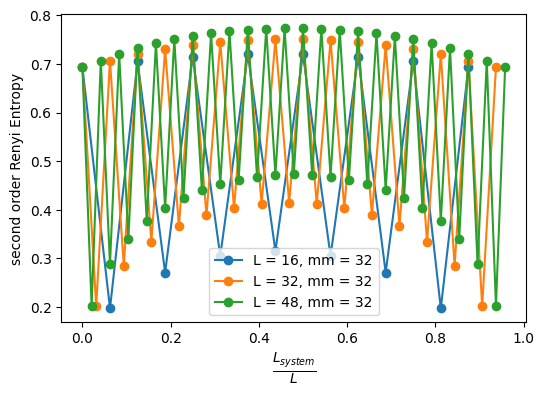

Text(0, 0.5, 'second order Renyi Entropy')

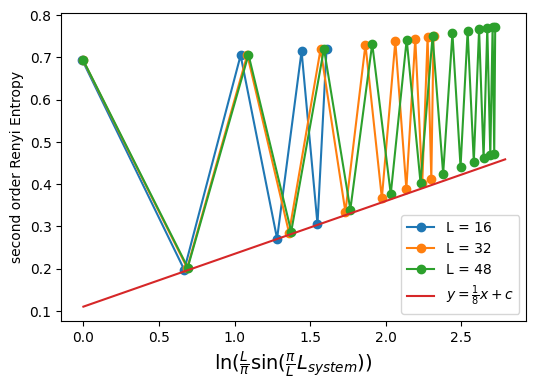

In [16]:
plt.figure(figsize = (6,4))
for i,N in enumerate([16,32,48]):
    plt.plot(np.arange(N-1)/N,totEE[i],'o-',label = f"L = {N}, mm = 32")

plt.legend()
plt.xlabel(r'$\frac{L_{system}}{L}$',fontsize = 14)
plt.ylabel('second order Renyi Entropy')
plt.show()
# plt.savefig("Sz_correlation_measurement")
plt.close()


plt.figure(figsize = (6,4))
for i,N in enumerate([16,32,48]):
  x = np.arange(N-1)#/N
  n = len(x) // 2
  x = x[:n] + 1
  x = np.log(N / np.pi * np.sin(np.pi / N * x))
  y = totEE[i]
  y = y[:n]
  plt.plot(x, y, 'o-', label = f"L = {N}")
x = np.arange(0,2.8,0.01)
y = 1/8 * x+0.11
plt.plot(x,y, label = r'$y = \frac{1}{8}x + c$')
plt.legend()
plt.xlabel(r'$\ln(\frac{L}{\pi}\sin(\frac{\pi}{L}L_{system}))$',fontsize = 14)
plt.ylabel('second order Renyi Entropy')